In [69]:
%matplotlib inline

In [70]:
import matplotlib
import matplotlib.pyplot as plt

In [71]:
import random
from datetime import datetime, timedelta
import io
import numpy as np
import heapq
import json
import operator
import pandas as pd
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from stop_words import get_stop_words
import json

import numpy.random as nprnd

stop_words = get_stop_words('english')


In [72]:
path_to_data = '../data/'

##########################
# load files #                           
##########################

training = pd.read_csv(path_to_data + 'training_set.csv', sep=',', header=0)
#training_info = pd.read_csv(path_to_data + 'training_info.csv', sep=',', header=0)
training_info = pd.read_csv(path_to_data+"training_info2.csv",sep=',', header=0, index_col=0)
test = pd.read_csv(path_to_data + 'test_set.csv', sep=',', header=0)
#test_info = pd.read_csv(path_to_data + 'test_info.csv', sep=',', header=0)
test_info = pd.read_csv(path_to_data+"test_info2.csv",sep=',', header=0, index_col=0)

global sent_to
with io.open('../data/sent_to.json') as json_data:
    sent_to = json.load(json_data)

global received_from
with io.open('../data/received_from.json') as json_data:
    received_from = json.load(json_data)

In [73]:
# Correct dates and put datetime format
# We do that because we noticed test_set is only composed of email posterior to the ones of train_set. 
# Datetime format allows to simulate posteriority in our train/test split
from datetime import datetime

for row in training_info.sort(['date']).iterrows():
    date = row[1]['date']
    if date[:3] == '000':
        date = '2' + date[1:]
        
    training_info.loc[row[0], 'date'] = datetime.strptime(date, '%Y-%m-%d %H:%M:%S')

for row in test_info.sort(['date']).iterrows():
    date = row[1]['date']
        
    test_info.loc[row[0], 'date'] = datetime.strptime(date, '%Y-%m-%d %H:%M:%S')

/Users/christophelanternier/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
/Users/christophelanternier/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:13: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


## Functions

In [4]:
def most_similar_sklearn(array_embedding_sparse, mail_tfidf, n):
    
    similarities = cosine_similarity(array_embedding_sparse, mail_tfidf)
    if int(round(sorted(similarities[:,0], reverse=True)[0])) == 1:
        closest_ids = similarities[:,0].argsort()[::-1][1:]
    else:
        closest_ids = similarities[:,0].argsort()[::-1]
    
    return closest_ids[:n], similarities

def get_sender(query_mid, training):
    for row in training.iterrows():
        mids = row[1]['mids'].split()
        for mid in mids:
            if int(mid) == query_mid:
                sender = row[1]['sender']
                break
    return sender


def get_10_recipients(closest_ids_per_sender, training_info, similarities):
    dic_of_recipients = {}
    #weight = len(closest_ids_per_sender)+1
    for idx in closest_ids_per_sender:
        recipients = training_info.loc[idx,'recipients'].split()
        for recipient in recipients:
            if '@' in recipient:
                dic_of_recipients[recipient] = dic_of_recipients.get(recipient, 0) + similarities[idx][0]
    
    norm = sum(dic_of_recipients.values())
    for k,v in dic_of_recipients.iteritems():
        dic_of_recipients[k] = float(v)/norm
        
    return dic_of_recipients

def get_recency_features(X_train_info_sender, mail_date, n_recency_features):    
    dic_recency = {}
    df_last_sent_emails = X_train_info_sender[X_train_info_sender.date<= mail_date].sort_values(by = 'date', ascending = False)[:n_recency_features]
    for row in df_last_sent_emails.iterrows():
        recipients = row[1]['recipients'].split()
        for recipient in recipients:
            if '@' in recipient:
                dic_recency[recipient] = dic_recency.get(recipient, 0) + 1
    norm = sum(dic_recency.values())
    for k,v in dic_recency.iteritems():
        dic_recency[k] = float(v)/norm
    
    return dic_recency

def mean_ap(suggested_10_recipients, ground_truth):
    MAP = 0
    correct_guess = 0
    for i, suggestion in enumerate(suggested_10_recipients):
        if suggestion in ground_truth:
            correct_guess +=1
            MAP += float(correct_guess)/(i+1)
    MAP = float(MAP)/min(10, len(ground_truth))
    return MAP

def header_address_ressemblance(text, address):
    head = text[:10].lower()
    name = address[:address.index('@')].split('.')
    for n in name:
        if len(n)>2:
            if n in head:
                return True
    return False

def generate_features(mail_tfidf, mail_date, ground_truth, sender, n, n_recency_features, mail_header):
    
    X_train_info_sender = X_train_info[(X_train_info.sender == sender) & (X_train_info.date<mail_date) & (X_train_info.date>(mail_date-timedelta(days = 180)))]
    print X_train_info_sender.shape
    index_sender = X_train_info_sender.index.values
    X_train_info_sender.index = range(X_train_info_sender.shape[0])
    array_embedding_sparse_sender = array_embedding_sparse[index_sender]

    closest_ids_per_sender, similarities = most_similar_sklearn(array_embedding_sparse_sender, mail_tfidf, n)

    dic_recency = get_recency_features(X_train_info_sender, mail_date, n_recency_features)

    dic_of_recipients = get_10_recipients(closest_ids_per_sender, X_train_info_sender, similarities)

    new_features_per_mail = np.zeros((len(dic_of_recipients), 5))
    labels_per_mail = np.zeros((len(dic_of_recipients), 1))
    index = 0
    for k,v in dic_of_recipients.iteritems():
        KNNScore = v
        NSF = sent_to[sender][k]
        NRF = 0
        if sender in received_from.keys():
            NRF = received_from[sender].get(k, 0)

        recency = 0
        if k in dic_recency.keys():
            recency = dic_recency[k]
        
        if ground_truth != None:
            if k in ground_truth:
                labels_per_mail[index, :] = 1
                
        head = 1.0 * header_address_ressemblance(mail_header, k)

        new_features_per_mail[index, :] = [KNNScore, NSF, NRF, recency, head]
        index +=1

    return new_features_per_mail, labels_per_mail, dic_of_recipients

In [74]:
#Declare Global variables:
global X_train_info
global X_test_info
global array_embedding_sparse

In [107]:
submission = False
training_info = training_info.sort_values(by='date')
#test_info = test_info.sort_values(by='date')

if submission:
    # submission procedure
    X_train_info = training_info
    X_test_info = test_info
    
else:
    # test procedure
    split_date=datetime(2001, 6, 25)
    X_train_info = training_info[training_info.date <= split_date]
    
    #Randomize selection of test set:
    X_test_info = training_info[training_info.date > split_date]
    mask = nprnd.choice(range(X_test_info.shape[0]), size=1000, replace=False)
    X_test_info.index = range(X_test_info.shape[0])
    X_test_info = X_test_info[X_test_info.index.isin(mask)]
    

In [112]:
training_info[training_info.date > split_date].shape

(15753, 5)

In [108]:
if submission:
    tfidf = TfidfVectorizer(stop_words = stop_words)
    array_embedding_sparse = tfidf.fit_transform(np.concatenate((X_train_info['body'].values,X_test_info['body'].values)))
    array_embedding_sparse = array_embedding_sparse[:X_train_info.shape[0]]
else:
    #With porter stemming:
    #tfidf = TfidfVectorizer(tokenizer= tokenize, stop_words = stop_words)
    #Without stemming:
    tfidf = TfidfVectorizer(stop_words = stop_words)
    array_embedding_sparse = tfidf.fit_transform(X_train_info['body'].values)

In [109]:
test_number_of_past_mails = {}
count = 0
t_100 = datetime.now()
for query_id in X_test_info.index.values:
    count+=1
    if count%100==0:
        print count
        print datetime.now()-t_100
        t_100 = datetime.now()

    # Get info on considered mail
    mail = X_test_info['body'][query_id]
    mail_tfidf = tfidf.transform([mail])
    mail_date = X_test_info['date'][query_id]
    #ground_truth = X_test_info['recipients'][query_id].split()
    sender = X_test_info['sender'][query_id]
    
    X_train_info_sender = X_train_info[(X_train_info.sender == sender) & (X_train_info.date<mail_date)]
    if sender in test_number_of_past_mails.keys():
        test_number_of_past_mails[sender][mail_date] = X_train_info_sender.shape[0]
    else:
        test_number_of_past_mails[sender] = {}
        test_number_of_past_mails[sender][mail_date] = X_train_info_sender.shape[0]

100
0:00:00.732502
200
0:00:00.774643
300
0:00:00.707163
400
0:00:00.675501
500
0:00:00.719034


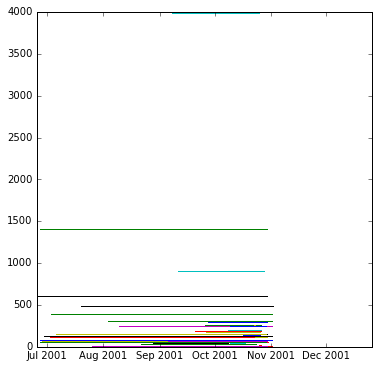

In [110]:

plt.figure(figsize=(6, 6))
for sender in test_number_of_past_mails.keys():
    
    datetimes = np.array(test_number_of_past_mails[sender].keys())
    values = np.array(test_number_of_past_mails[sender].values())[datetimes.argsort()]
    datetimes = sorted(datetimes)
    dates = matplotlib.dates.date2num(datetimes)
    plt.plot_date(dates, values, '-')

plt.show()

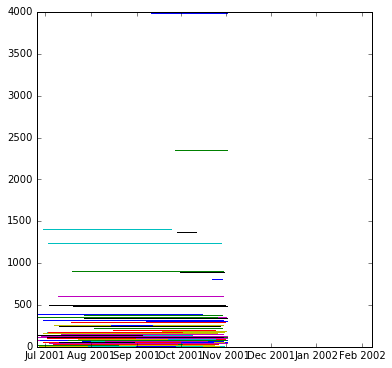

In [101]:

plt.figure(figsize=(6, 6))
for sender in test_number_of_past_mails.keys():
    
    datetimes = np.array(test_number_of_past_mails[sender].keys())
    values = np.array(test_number_of_past_mails[sender].values())[datetimes.argsort()]
    datetimes = sorted(datetimes)
    dates = matplotlib.dates.date2num(datetimes)
    plt.plot_date(dates, values, '-')

plt.show()

In [135]:
new_features_all = np.load('../data/new_features_all_normalized_header_recency2.npy')
labels_all = np.load('../data/labels_all_normalized_header_recency2.npy')

In [138]:
new_features_all = new_features_all[1000000:1002000, :]
labels_all = labels_all[1000000:1002000, :]

In [153]:
KNN_true = new_features_all[:, [0]][labels_all == 1]
recency_true = new_features_all[:, [3]][labels_all == 1]
print recency_true.shape

(119,)


In [154]:
KNN_false = new_features_all[:, [0]][labels_all == 0]
recency_false = new_features_all[:, [3]][labels_all == 0]

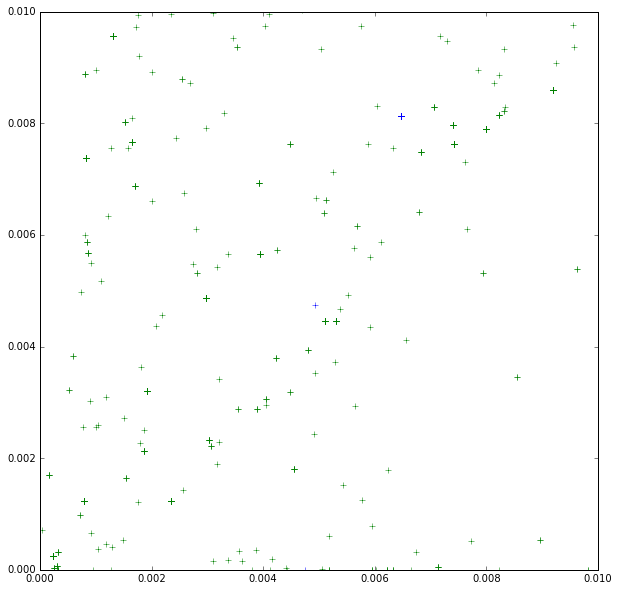

In [155]:
plt.figure(figsize=(10,10))
plt.plot(recency_true, KNN_true, '+')
plt.plot(recency_false, KNN_false, '+')
plt.ylim([0,0.01])
plt.xlim([0,0.01])
plt.show()